# ML Zoomcamp 
## Homework #4

Car Prices Dataset -- Evaluation

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, roc_auc_score, precision_recall_fscore_support, PrecisionRecallDisplay
from sklearn.feature_extraction import DictVectorizer



print(pd.__version__)

2.0.3


In [85]:
# import urllib.request

# url = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv'
filename = './data/cars.csv'

# urllib.request.urlretrieve(url, filename)

In [86]:
use_cols = ['Make', 'Model', 'Year', 'Engine HP',
       'Engine Cylinders', 'Transmission Type', 'Vehicle Style',
       'highway MPG', 'city mpg', 'MSRP']
data = pd.read_csv(filename, usecols=use_cols)
data.head()

,Make,Model,Year,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,highway MPG,city mpg,MSRP
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


Data Preparation

In [87]:
data.columns = data.columns.str.replace(' ', '_').str.lower()
data.fillna(0, inplace=True)
data.rename(columns={'msrp': 'price'}, inplace=True)
data.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable above_average

In [88]:
data['above_average'] = (data.price >= data.price.mean()).astype(int)
data.drop(columns=['price'], inplace=True)
data.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,0


Split the data into 3 parts: train/validation/test with 60/20/20% distribution

In [89]:
train, test = train_test_split(data, test_size=0.2, random_state=1)
test, val = train_test_split(test, test_size=0.5, random_state=1)
print(train.shape, test.shape, val.shape)

(9531, 10) (1191, 10) (1192, 10)


Q1) ROC AUC feature importance - which numerical feature has the highest AUC among given features

A1) engine_hp has the highest AUC compared to engine_cylinders/highway_mpg/city_mpg

In [90]:
num_features = data.select_dtypes(include=np.number).columns.tolist()
clf = LogisticRegression(random_state=1)
y_true = train['above_average'].values

scores = []
for f in num_features[:-1]:    
    X_train = train[f].values.reshape(-1, 1)
    clf.fit(X_train, y_true)
    y_pred = clf.predict_proba(X_train)[:, 1]
    score = roc_auc_score(y_true, y_pred)
    print(f"Feature ={f}= has Score: {score}")
    scores.append(score)

scores_df = pd.DataFrame({'feature': num_features[:-1], 'score': scores})
scores_df['score'] = scores_df['score'].apply(lambda x: -1*x if x < 0.5 else x)
scores_df.sort_values(by='score', ascending=False, inplace=True)
scores_df

Feature =year= has Score: 0.31163144065980647
Feature =engine_hp= has Score: 0.9166069742463354
Feature =engine_cylinders= has Score: 0.7668524028872186
Feature =highway_mpg= has Score: 0.6319629061605238
Feature =city_mpg= has Score: 0.67256247732796


,feature,score
1,engine_hp,0.916607
2,engine_cylinders,0.766852
4,city_mpg,0.672562
3,highway_mpg,0.631963
0,year,-0.311631


Q2) Training the model: Apply one-hot-encoding using DictVectorizer and train the logistic regression model. What's the AUC of this model on the validation set?

A2) 0.979 which is the closest to Score: 0.986 that we get on validation set

In [91]:
train

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
2711,Mercedes-Benz,CLK-Class,2007,382.0,8.0,AUTOMATIC,Coupe,22,15,1
333,Nissan,370Z,2016,332.0,6.0,MANUAL,Coupe,26,18,0
9377,GMC,Sierra 1500,2017,285.0,6.0,AUTOMATIC,Extended Cab Pickup,24,18,0
939,Porsche,911,2016,350.0,6.0,MANUAL,Convertible,26,19,1
5675,Volkswagen,GTI,2013,200.0,4.0,MANUAL,4dr Hatchback,31,21,0
...,...,...,...,...,...,...,...,...,...,...
7813,Audi,Q5,2016,272.0,6.0,AUTOMATIC,4dr SUV,26,18,1
10955,Toyota,Tundra,2015,381.0,8.0,AUTOMATIC,Crew Cab Pickup,17,13,1
905,Saab,900,1997,150.0,4.0,MANUAL,4dr Hatchback,26,18,0
5192,Pontiac,G6,2009,164.0,4.0,AUTOMATIC,Coupe,33,22,0


In [92]:
# //change numpy display options for format
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [93]:
num_features = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
cat_features = ['make', 'model', 'transmission_type', 'vehicle_style']

dv = DictVectorizer(sparse=False)
train_dict = train[num_features + cat_features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
y_train = train['above_average'].values
val_dict = val[num_features + cat_features].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_val = val['above_average'].values
test_dict = test[num_features + cat_features].to_dict(orient='records')
X_test = dv.transform(test_dict)
y_test = test['above_average'].values

X_train



array([[15.000, 8.000, 382.000, ..., 0.000, 0.000, 2007.000],
       [18.000, 6.000, 332.000, ..., 0.000, 0.000, 2016.000],
       [18.000, 6.000, 285.000, ..., 0.000, 0.000, 2017.000],
       ...,
       [18.000, 4.000, 150.000, ..., 0.000, 0.000, 1997.000],
       [22.000, 4.000, 164.000, ..., 0.000, 0.000, 2009.000],
       [16.000, 6.000, 255.000, ..., 1.000, 0.000, 2003.000]])

In [94]:
train_dict[0]

{'year': 2007,
 'engine_hp': 382.0,
 'engine_cylinders': 8.0,
 'highway_mpg': 22,
 'city_mpg': 15,
 'make': 'Mercedes-Benz',
 'model': 'CLK-Class',
 'transmission_type': 'AUTOMATIC',
 'vehicle_style': 'Coupe'}

In [95]:
# // create model
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)
y_val_pred = model.predict_proba(X_val)[:, 1]
score = roc_auc_score(y_val, y_val_pred)
print(f"Score: {np.round(score,3)}")


Score: 0.986


Q3) Precision and Recall -- At which threshold does precision and recall curves intersect?

A3) 0.48 -- As we can see, the precision and recall really meets close to Threshold: 0.43 Precision: 0.898 Recall: 0.895


Threshold: 0.0 Precision: 0.273 Recall: 1.0
Threshold: 0.01 Precision: 0.477 Recall: 1.0
Threshold: 0.02 Precision: 0.523 Recall: 1.0
Threshold: 0.03 Precision: 0.554 Recall: 0.997
Threshold: 0.04 Precision: 0.575 Recall: 0.997
Threshold: 0.05 Precision: 0.609 Recall: 0.997
Threshold: 0.06 Precision: 0.629 Recall: 0.997
Threshold: 0.07 Precision: 0.649 Recall: 0.994
Threshold: 0.08 Precision: 0.665 Recall: 0.994
Threshold: 0.09 Precision: 0.676 Recall: 0.994
Threshold: 0.1 Precision: 0.686 Recall: 0.994
Threshold: 0.11 Precision: 0.698 Recall: 0.994
Threshold: 0.12 Precision: 0.719 Recall: 0.991
Threshold: 0.13 Precision: 0.725 Recall: 0.988
Threshold: 0.14 Precision: 0.729 Recall: 0.978
Threshold: 0.15 Precision: 0.738 Recall: 0.978
Threshold: 0.16 Precision: 0.743 Recall: 0.969
Threshold: 0.17 Precision: 0.745 Recall: 0.969
Threshold: 0.18 Precision: 0.765 Recall: 0.969
Threshold: 0.19 Precision: 0.77 Recall: 0.969
Threshold: 0.2 Precision: 0.773 Recall: 0.963
Threshold: 0.21 Precisi

Threshold: 0.54 Precision: 0.924 Recall: 0.858
Threshold: 0.55 Precision: 0.924 Recall: 0.858
Threshold: 0.56 Precision: 0.93 Recall: 0.855
Threshold: 0.57 Precision: 0.936 Recall: 0.855
Threshold: 0.58 Precision: 0.939 Recall: 0.855
Threshold: 0.59 Precision: 0.939 Recall: 0.852
Threshold: 0.6 Precision: 0.942 Recall: 0.843
Threshold: 0.61 Precision: 0.941 Recall: 0.84
Threshold: 0.62 Precision: 0.947 Recall: 0.831
Threshold: 0.63 Precision: 0.951 Recall: 0.828
Threshold: 0.64 Precision: 0.951 Recall: 0.828
Threshold: 0.65 Precision: 0.954 Recall: 0.825
Threshold: 0.66 Precision: 0.957 Recall: 0.822
Threshold: 0.67 Precision: 0.96 Recall: 0.822
Threshold: 0.68 Precision: 0.967 Recall: 0.822
Threshold: 0.69 Precision: 0.967 Recall: 0.812
Threshold: 0.7 Precision: 0.967 Recall: 0.809
Threshold: 0.71 Precision: 0.967 Recall: 0.806
Threshold: 0.72 Precision: 0.966 Recall: 0.797
Threshold: 0.73 Precision: 0.966 Recall: 0.791
Threshold: 0.74 Precision: 0.966 Recall: 0.778
Threshold: 0.75 Pr

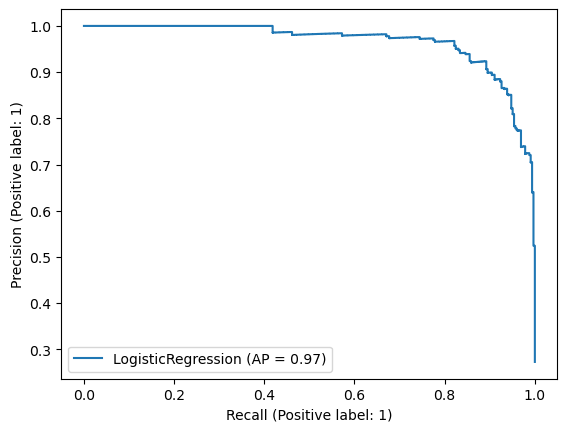

In [96]:
thresholds = np.linspace(0, 1.0, 101)

for th in thresholds:
    y_val_pred = (model.predict_proba(X_val)[:, 1] >= th).astype(int)
    precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)
    print(f"Threshold: {np.round(th,2)} Precision: {np.round(precision[1],3)} Recall: {np.round(recall[1],3)}")
    
display = PrecisionRecallDisplay.from_estimator(model, X_val, y_val)

    

Q4) F1 Score -- At which threshold is F1 score maximal?

A4) 0.52 -- The closest is Threshold: 0.5 F1-Score: 0.908 when it is maximum

In [97]:
thresholds = np.linspace(0, 1.0, 101)

for th in thresholds:
    y_val_pred = (model.predict_proba(X_val)[:, 1] >= th).astype(int)
    precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)
    print(f"Threshold: {np.round(th,2)} F1-Score: {np.round(fscore[1],3)} ")
    

Threshold: 0.0 F1-Score: 0.428 
Threshold: 0.01 F1-Score: 0.646 
Threshold: 0.02 F1-Score: 0.687 
Threshold: 0.03 F1-Score: 0.712 
Threshold: 0.04 F1-Score: 0.73 
Threshold: 0.05 F1-Score: 0.756 
Threshold: 0.06 F1-Score: 0.771 
Threshold: 0.07 F1-Score: 0.785 
Threshold: 0.08 F1-Score: 0.797 
Threshold: 0.09 F1-Score: 0.804 
Threshold: 0.1 F1-Score: 0.812 
Threshold: 0.11 F1-Score: 0.82 
Threshold: 0.12 F1-Score: 0.833 
Threshold: 0.13 F1-Score: 0.836 
Threshold: 0.14 F1-Score: 0.836 
Threshold: 0.15 F1-Score: 0.841 
Threshold: 0.16 F1-Score: 0.841 
Threshold: 0.17 F1-Score: 0.842 
Threshold: 0.18 F1-Score: 0.855 
Threshold: 0.19 F1-Score: 0.858 
Threshold: 0.2 F1-Score: 0.858 
Threshold: 0.21 F1-Score: 0.859 
Threshold: 0.22 F1-Score: 0.865 
Threshold: 0.23 F1-Score: 0.87 
Threshold: 0.24 F1-Score: 0.876 
Threshold: 0.25 F1-Score: 0.879 
Threshold: 0.26 F1-Score: 0.88 
Threshold: 0.27 F1-Score: 0.891 
Threshold: 0.28 F1-Score: 0.891 
Threshold: 0.29 F1-Score: 0.897 
Threshold: 0.3 F1

Q5) 5-Fold CV -- How large is standard deviation of the scores across different folds

A5) 0.003 


In [98]:
cv = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores=[]
for train_idx, val_idx in cv.split(X_train, y_train):
    X_train_fold = X_train[train_idx]
    y_train_fold = y_train[train_idx]
    X_val_fold = X_train[val_idx]
    y_val_fold = y_train[val_idx]
    
    print(X_train_fold.shape, X_val_fold.shape)
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_fold, y_train_fold)
    auc_score = roc_auc_score(y_val_fold, model.predict_proba(X_val_fold)[:, 1])
    print(f"Score: {np.round(auc_score,3)}")
    auc_scores.append(auc_score)

print(f"Mean Score: {np.round(np.mean(auc_scores),3)}")
print(f"Std Score: {np.round(np.std(auc_scores),3)}")

(7624, 974) (1907, 974)
Score: 0.978
(7625, 974) (1906, 974)
Score: 0.977
(7625, 974) (1906, 974)
Score: 0.978
(7625, 974) (1906, 974)
Score: 0.98
(7625, 974) (1906, 974)
Score: 0.985
Mean Score: 0.98
Std Score: 0.003


Q6) Hyperparameter Tuning -- Which C leads to the best mean score

A6) 10 == gives the best AUC score of 0.983 for C = 10

In [99]:
C = [0.01, 0.1, 0.5, 10]
params = {'C': C}
cv = KFold(n_splits=5, shuffle=True, random_state=1)
model = LogisticRegression(solver='liblinear', max_iter=1000)
cv_scores = GridSearchCV(model, param_grid= params, cv=cv, scoring='roc_auc', n_jobs=-1)
cv_scores.fit(X_train, y_train)
print(f"Best C param: {cv_scores.best_params_}")
print(f"Best CV AUC Score: {np.round(cv_scores.best_score_,3)}")


Best C param: {'C': 10}
Best CV AUC Score: 0.983
